# United States Income

In this first example, we will look at Income and Night light intensity throughout the United States. The income data comes from the [American Community Survey](https://www.census.gov/geo/maps-data/data/tiger-data.html). We are interested in the [zip code level data](http://www2.census.gov/geo/tiger/TIGER_DP/2016ACS/ACS_2016_5YR_ZCTA.gdb.zip) and the associated [meta data](http://www2.census.gov/geo/tiger/TIGER_DP/2016ACS/Metadata/ZCTA_METADATA_2016.txt). After looking through the meta data, let's first look at the fields for population (B00001e1) and median household income (B19013e1).

The data are in a geodatabase, which the python library [fiona](http://toblerity.org/fiona/) can read, as well as many other data sources.

In [1]:
import fiona
import os
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
DATA_PATH = '/data/PyDataSpatialAnalysis/data'
ams_path = os.path.join(DATA_PATH, 'ACS_2016_5YR_ZCTA.gdb')

To see how the actual data are structured, we can first check layers are available:

In [16]:
fiona.listlayers(ams_path)

['X00_COUNTS',
 'X01_AGE_AND_SEX',
 'X02_RACE',
 'X03_HISPANIC_OR_LATINO_ORIGIN',
 'X04_ANCESTRY',
 'X05_FOREIGN_BORN_CITIZENSHIP',
 'X06_PLACE_OF_BIRTH',
 'X07_MIGRATION',
 'X08_COMMUTING',
 'X09_CHILDREN_HOUSEHOLD_RELATIONSHIP',
 'X10_GRANDPARENTS_GRANDCHILDREN',
 'X11_HOUSEHOLD_FAMILY_SUBFAMILIES',
 'X12_MARITAL_STATUS_AND_HISTORY',
 'X13_FERTILITY',
 'X14_SCHOOL_ENROLLMENT',
 'X15_EDUCATIONAL_ATTAINMENT',
 'X16_LANGUAGE_SPOKEN_AT_HOME',
 'X17_POVERTY',
 'X18_DISABILITY',
 'X19_INCOME',
 'X20_EARNINGS',
 'X21_VETERAN_STATUS',
 'X22_FOOD_STAMPS',
 'X23_EMPLOYMENT_STATUS',
 'X24_INDUSTRY_OCCUPATION',
 'X25_HOUSING_CHARACTERISTICS',
 'X26_GROUP_QUARTERS',
 'X27_HEALTH_INSURANCE',
 'X99_IMPUTATION',
 'METADATA_ZCTA_2016',
 'ACS_2016_5YR_ZCTA']

To see how data for each zip code look, let's print the first entry

In [17]:
with fiona.open(ams_path, layer='X00_COUNTS') as f:
    iter_ = iter(f)
    pprint(next(iter_))
    pprint(next(iter_))

{'geometry': None,
 'id': '3',
 'properties': OrderedDict([('GEOID', '86000US00601'),
                            ('B00001e1', 1396.0),
                            ('B00001m1', -1.0),
                            ('B00002e1', 661.0),
                            ('B00002m1', -1.0)]),
 'type': 'Feature'}
{'geometry': None,
 'id': '4',
 'properties': OrderedDict([('GEOID', '86000US00602'),
                            ('B00001e1', 2175.0),
                            ('B00001m1', -1.0),
                            ('B00002e1', 1150.0),
                            ('B00002m1', -1.0)]),
 'type': 'Feature'}


So we have a all of the data in the layer X00_COUNTS in the properties. The actual geometry is missing. We will have to fill that in later by joining on the GEOID

The population data will be in X00_COUNTS and the median income will be in X19_INCOME. We could use geopandas to easily open and structure the data into a dataframe, but reading in that much data will stretch the memory on my laptop. Instead, we can use fiona to extract exactly what we want

In [47]:
with fiona.open(ams_path, layer='X01_AGE_AND_SEX') as f:
    population_dict = {e['properties']['GEOID']: e['properties']['B01001e1'] for e in f}
with fiona.open(ams_path, layer='X19_INCOME') as f:
    income_dict = {e['properties']['GEOID']: e['properties']['B19013e1'] for e in f}
df = pd.concat([pd.Series(population_dict, name='population'), pd.Series(income_dict, name='income')], axis=1)

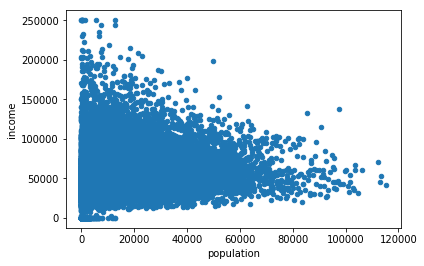

In [48]:
df.plot.scatter(x='population', y='income')

# NightLights

In [2]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely import geometry
import numpy as np

In [21]:
gdf = gpd.read_file(DATA_PATH + '/ZCTA_2010Census_DP1')
gdf['area'] = gdf.geometry.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs').area
gdf['pop_density'] = gdf['DP0010001'] / gdf['area'] * 1000*1000
gdf['log_pop_density'] = gdf.pop_density.map(lambda x: np.log(x))

In [29]:
gdf['log_pop_density'] = gdf.pop_density.map(lambda x: np.log(x))

/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [31]:
lower_48_cut = geometry.Polygon([(-125, 50), (-60, 50), (-60,20), (-125, 20)])
lower_48 = gdf[gdf.geometry.intersects(lower_48_cut)]
lower_48 = lower_48[lower_48.pop_density > 0]
lower_48['log_pop_density'] = gdf.pop_density.map(lambda x: np.log(x))
#tmp.plot(column='DP0010001')

/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


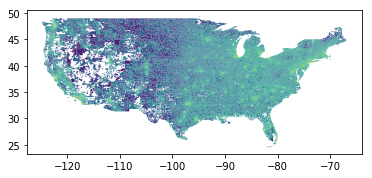

In [32]:
lower_48[lower_48.pop_density > 0].plot(column='log_pop_density')

In [34]:
gdf.shape

(33120, 198)

In [36]:
df.head()

,population,income
86000US00601,1396.0,11507.0
86000US00602,2175.0,15511.0
86000US00603,3815.0,16681.0
86000US00606,493.0,11648.0
86000US00610,1663.0,17751.0


In [49]:
df.index = df.index.map(lambda x: x[-5:])

In [50]:
tmp = gdf.set_index('GEOID10')
res = tmp[['DP0010001', 'area', 'pop_density', 'geometry']].join(df)

In [61]:
res.head()

,DP0010001,area,pop_density,geometry,population,income,mean_nightlight
GEOID10,,,,,,,
04757,2870,3.383647e+08,8.481973,POLYGON ((-68.08094999999992 46.56745699999999...,2880.0,51036.0,2.947917
04758,1498,9.119880e+07,16.425655,"POLYGON ((-67.906499 46.52525900000012, -67.90...",1432.0,38967.0,6.166667
04760,795,2.603353e+08,3.053754,POLYGON ((-67.85272099999997 46.37206700000013...,694.0,36513.0,0.863578
04975,48,1.423188e+05,337.270891,"POLYGON ((-69.58945 44.62187599999999, -69.589...",132.0,0.0,0.000000
04976,9903,2.626303e+08,37.706994,POLYGON ((-69.73503399999993 44.78785000000005...,9722.0,32609.0,7.515674


### Nightlights Rasterio

In [3]:
nightlights = rasterio.open(DATA_PATH + '/F182013.v4c_web.stable_lights.avg_vis.tif')

In [4]:
nightlights.crs.to_string()

'+init=epsg:4326'

In [5]:
def geom_to_mean_light(geom):
    try:
        out_image, out_transform = mask(nightlights, [geometry.mapping(geom)], crop=True)
        res = out_image.mean()
    except ValueError:
        res = -1
    return res

In [56]:
reproj = res.to_crs(nightlights.crs.to_string())

In [59]:
res['mean_nightlight'] = reproj.geometry.map(geom_to_mean_light)

In [76]:
import seaborn as sns
from scipy.stats import kendalltau

/Users/dillon/Envs/pydata/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


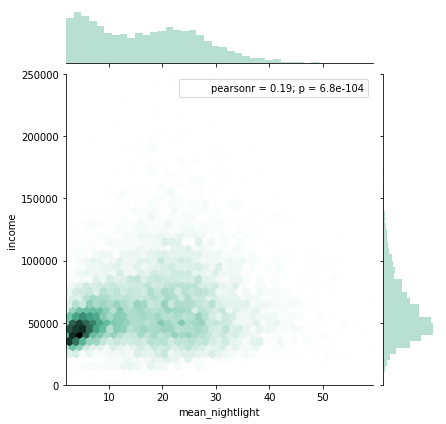

In [118]:
tmp = res[(res.population > 5000)& (res.mean_nightlight > 2)]
sns.jointplot(tmp.mean_nightlight, tmp.income, kind="hex", color="#4CB391")

In [94]:
res.head()

,DP0010001,area,pop_density,geometry,population,income,mean_nightlight
GEOID10,,,,,,,
04757,2870,3.383647e+08,8.481973,POLYGON ((-68.08094999999992 46.56745699999999...,2880.0,51036.0,2.947917
04758,1498,9.119880e+07,16.425655,"POLYGON ((-67.906499 46.52525900000012, -67.90...",1432.0,38967.0,6.166667
04760,795,2.603353e+08,3.053754,POLYGON ((-67.85272099999997 46.37206700000013...,694.0,36513.0,0.863578
04975,48,1.423188e+05,337.270891,"POLYGON ((-69.58945 44.62187599999999, -69.589...",132.0,0.0,0.000000
04976,9903,2.626303e+08,37.706994,POLYGON ((-69.73503399999993 44.78785000000005...,9722.0,32609.0,7.515674


/Users/dillon/Envs/pydata/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


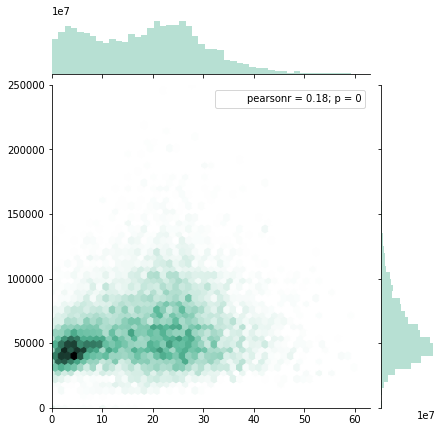

In [116]:
income = np.hstack(res.apply(lambda x: np.repeat(x.income, x.population), axis=1))
mean_nightlights = np.hstack(res.apply(lambda x: np.repeat(x.mean_nightlight, x.population), axis=1))
sns.jointplot(mean_nightlights, income, kind="hex", color="#4CB391")

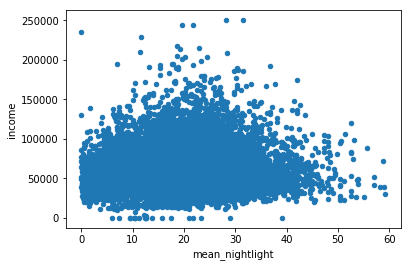

In [71]:
tmp = pd.DataFrame(res)
tmp = tmp[tmp.population > 5000]
tmp.plot.scatter(x='mean_nightlight', y='income')

In [6]:
county = gpd.read_file(DATA_PATH + '/County_2010Census_DP1')

In [7]:
cut_poly = geometry.Polygon([(-125, 50), (-60, 50), (-60,20), (-125, 20)])
county_reduced = county[county.geometry.intersects(cut_poly)]
county_reduced['area'] = county_reduced.geometry.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs').area
county_reduced['pop_density'] = county_reduced['DP0010001'] / county_reduced['area'] * 1000*1000
county_reduced['log_pop_density'] = county_reduced.pop_density.map(lambda x: np.log(x))

/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


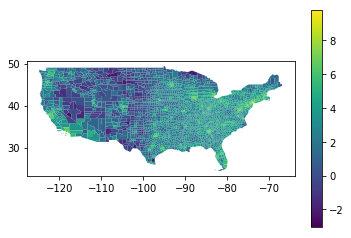

In [8]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
county_reduced['log_pop_density'] = county_reduced.pop_density.map(lambda x: np.log(x))
county_reduced.plot(ax=ax, column='log_pop_density', legend=True)

In [8]:
tmp = county_reduced.geometry.to_crs(nightlights.crs.to_string())
county_reduced['mean_nightlight'] = tmp.geometry.map(geom_to_mean_light)

/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


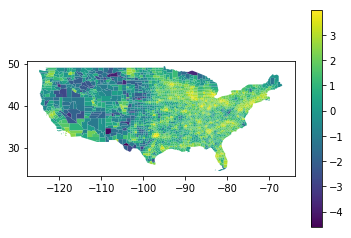

In [11]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
county_reduced['log_nightlight'] = county_reduced.mean_nightlight.map(lambda x: np.log(x))
county_reduced.plot(ax=ax, column='log_nightlight', legend=True)

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [13]:
germany = world[world.iso_a3 == 'DEU'].geometry.values[0]
out_image, out_transform = mask(nightlights, [geometry.mapping(germany)], crop=True)

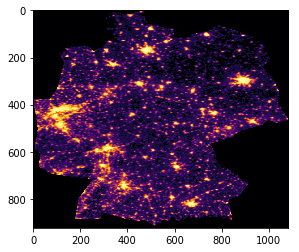

In [15]:
plt.imshow(out_image[0], cmap='inferno')


In [7]:
world[world.name == 'Germany']

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
41,82329758.0,Europe,Germany,DEU,2918000.0,"POLYGON ((9.921906365609232 54.98310415304803,..."
